##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
# %pip install pandas
# %pip install pyarrow
# %pip install numpy
# %pip install scikit-learn
# %pip install imbalanced-learn
# %pip install matplotlib
# %pip install imblearn
# %pip install seaborn
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [1]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

# NUS Team 54

**Members: Zhang Zhenjie, Ng Hock Leong, Caleb Tan Yong Yuan, Koh Yang Yi**

### Abstract

In this datathon project, we aim to address the observed trend of customer hesitation and disengagement during the insurance acquisition process at Singlife. Leveraging a comprehensive dataset, our objective is to derive actionable insights to identify critical touchpoints contributing to customer drop-off and unveil opportunities to streamline the application process and personalize communication. The primary focus is on predicting customer satisfaction and conversion rates. Our project is outlined as follows:

1. Preparing the Data
2. Data Visualization
3. Traning of Models
4. Refining of Models
5. Conclusion

## 1 Preparing the Data

### 1.1 Read in the Dataset

The file format of the dataset that is given to us is in parquet format and thus we need to use an engine to decode. In our case, we chose `pyarrow`. The command to install is located in the first cell of this notebook.

In [2]:
df = pd.read_parquet(filepath)

# We view the data frame first and notice that there are missing values 
print(df)

# Get a summary of the entire dataframe
summary_stats = df.describe()

          clntnum race_desc ctrycode_desc clttype stat_flag min_occ_date  \
19550  91b546e924   Chinese     Singapore       P    ACTIVE   2017-10-31   
4600   896bae548c   Chinese     Singapore       P    ACTIVE   2007-05-23   
13337  f364439ae6    Others     Singapore       P    ACTIVE   2019-08-31   
15074  70f319cfe1   Chinese     Singapore       P    ACTIVE   2021-10-18   
19724  2647a81328   Chinese     Singapore       P    ACTIVE   2018-07-20   
...           ...       ...           ...     ...       ...          ...   
11284  3363260248      None     Singapore       P    LAPSED   2016-08-01   
11964  c3509f0aef   Chinese     Singapore       P    ACTIVE   1990-03-20   
5390   6e44cfb3e7   Chinese     Singapore       P    ACTIVE   2007-12-31   
860    dd4e362f9f    Others     Singapore       P    ACTIVE   2007-09-01   
15795  3788d06ec7    Indian     Singapore       P    ACTIVE   2011-10-24   

       cltdob_fix cltsex_fix  flg_substandard  flg_is_borderline_standard  \
19550  197

### 1.2 Cleaning the Data

After reading in the data and doing an initial inspection, we notice that the dataframe is 17992x304 suggesting that there are 304 features and 17992 observations. However, we also noticed that there are various invalid values such as `NaN` and thus we would like to clean up the data before proceeding further.

In [3]:
# Convert target col to 0 or 1
df["f_purchase_lh"] = df["f_purchase_lh"].fillna(0)

# Identifiy numeric columns and fill null values with the median value
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Drop non-numeric cols
non_numeric_cols = df.select_dtypes(include=["string", "object"]).columns
df = df.drop(columns=non_numeric_cols)

y = df["f_purchase_lh"]
X = df.drop(columns=['f_purchase_lh'])

# View the cleaned data
print(X)
print(y)


       flg_substandard  flg_is_borderline_standard  flg_is_revised_term  \
19550              0.0                         0.0                  0.0   
4600               0.0                         0.0                  0.0   
13337              0.0                         0.0                  0.0   
15074              0.0                         0.0                  0.0   
19724              0.0                         0.0                  0.0   
...                ...                         ...                  ...   
11284              0.0                         0.0                  0.0   
11964              0.0                         0.0                  0.0   
5390               0.0                         0.0                  0.0   
860                0.0                         0.0                  0.0   
15795              0.0                         0.0                  0.0   

       flg_is_rental_flat  flg_has_health_claim  flg_has_life_claim  \
19550                 0.0   

### 1.4 Dimensionality Reduction
After cleaning the data and dropping those features that are non-numeric, we also notice that there are columns that have low variance. These columns are unlikely to make a big impact when training our model. We would thus like to do dimensionality reduction through the dropping of columns with low variance. Furthermore, this speeds up the model training speed and reduces computational load.

In [4]:
# Calculate the variance for each column
col_var = X.var()
print(col_var)

# Calculate the lower quartile of the variance to set as threshold
col_var.quantile(0.25)

flg_substandard                 0.036574
flg_is_borderline_standard      0.030262
flg_is_revised_term             0.000667
flg_is_rental_flat              0.011699
flg_has_health_claim            0.043905
                                 ...    
flg_hlthclaim_839f8a_ever       0.000000
recency_hlthclaim_839f8a       18.817906
flg_hlthclaim_14cb37_ever       0.000000
recency_hlthclaim_14cb37      102.454853
recency_giclaim                22.854705
Length: 89, dtype: float64


0.0049774776227598

From our analysis in the previous code chunk, we found that the bottom 25% of features have variance less than 0.004977. We deterimine that any features with variance lower than the 25th percentile variance should be dropped. Thus, it is appropriate to set the threshold level to be 0.005.

In [5]:
from sklearn.feature_selection import VarianceThreshold
from sklearn import set_config

# set the output to be pandas dataframe instead of numpy array
set_config(transform_output="pandas")

# Removing low variance columns
selector = VarianceThreshold(threshold=0.005)
X = selector.fit_transform(X)

# Inspect the dimension after removing columns
X.shape

(17992, 66)

We are now left with 66 features.

### 1.5 Min-Max Scaling

Next, we also notice that different features have different ranges and would like to scale the features so that all of them are between the values 0 and 1. The rationale for doing this is that for models that uses distance metric such as KNN, greater importance will be given to features that have higher nominal value. Thus, it is important to scale our features before training any models or doing any visualization. In our context, standardization is inappropriate as it will shift the mean to 0 which would not be realistic since some of the features are health claim amounts which is unlikely to have $\bar{x} = 0$

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## 2 Data Visulization and EDA

The reason for doing Data Visualization and Exploratory Data Analysis at this stage instead of before data manipulation is that the original data is noisy and has a lot of features. Not all the features would be relevant to our task at hand. Furthermore, doing visualizations amongst 304 features would be computationally slow and not meaningful at uncovering insights.

In [7]:
# create a temporary new dataframe to do visualizations
df_new = pd.concat([X, y], axis = 1)

### 2.1 Heat map

The code below plots a heat map which we aims to explore any correlation between the variables. We notice that indeed some variables are strongly correlated as indicated by the the light red regions. For example `flg_is_returned_mail` and `is_consent_to_call`. However, this also means that some of the variables we have are not fully independent which is possible to do Principal Component Analysis to further reduce the dimensions to without suffering too much information loss. However, we will not be doing that as only a few of the variables exhibits this dependence.

<AxesSubplot:>

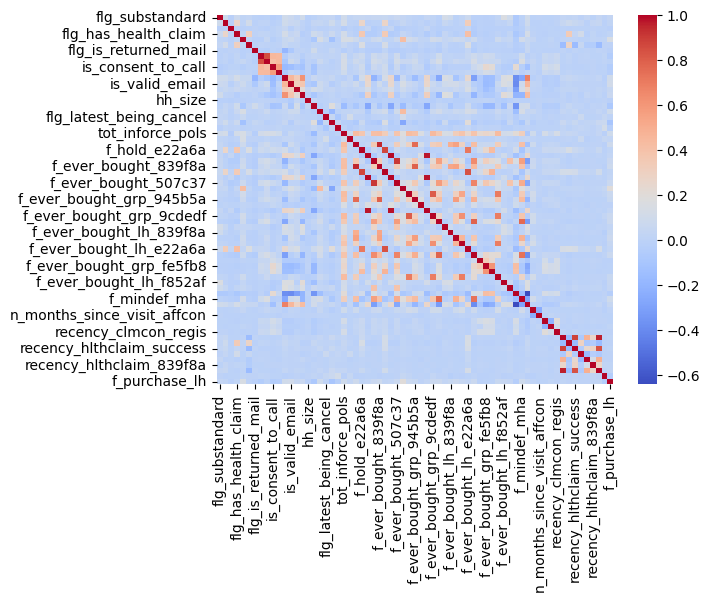

In [8]:
import seaborn as sns

sns.heatmap(df_new.corr(), cmap="coolwarm")

### 2.2 Check for Imbalance of Data

Checking that datasets are balanced is crucial for machine learning because imbalanced datasets can lead to biased and inaccurate models. When a dataset is imbalanced, meaning that certain classes have significantly fewer instances than others, the model may become biased towards the majority class. This imbalance can result in poor generalization to minority classes, leading to skewed predictions and reduced model accuracy.

Class Counts:
 0.0    17282
1.0      710
Name: f_purchase_lh, dtype: int64


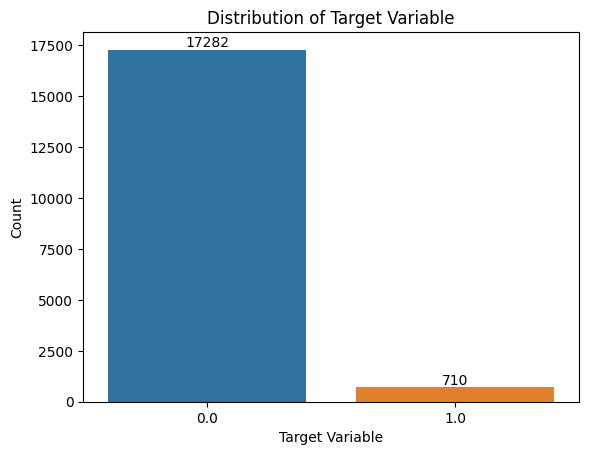

In [9]:
import matplotlib.pyplot as plt

class_counts = y.value_counts()

# Print class counts
print("Class Counts:\n", class_counts)

# Plot a countplot to visualize the distribution
ax = sns.countplot(x=y)

# Add labels above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.show()

### 2.3 Applying SMOTE (Synthetic Minority Oversampling Technique)

In the previous code chunk, we note that the dataset we have at hand is heavily imbalanced. Thus, we would like to balance the dataset. The technique we have chosen to balance the dataset is SMOTE (Synthetic Minority Oversampling Technique). SMOTE works by generating synthetic samples for the minority class, thereby balancing the class distribution. The technique involves identifying individual instances of the minority class and creating synthetic examples by interpolating between them and their nearest neighbors. This helps to enlarge the minority class and creates a more balanced dataset.

In [10]:
from collections import Counter
from imblearn.over_sampling import SMOTE

print('Before:', Counter(y))
X, y = SMOTE().fit_resample(X, y)
print('After:', Counter(y))

Before: Counter({0.0: 17282, 1.0: 710})
After: Counter({0.0: 17282, 1.0: 17282})


## 3 Training of Models

In this section we would like to explore various machine learning models that will help us to predict whether a customer will purchase life or health insurance products within the next three months.

### 3.1 $80-20$ Train-test Split

For this project, we would like to use the conventional 80-20 train test split. This allows us to set aside 20 percent of the data to validate and assess our models' performance.

In [11]:
from sklearn.model_selection import train_test_split

# set seed
seed = 69
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

### 3.2 Decision Tree

We first try to test out a simple model, namely decision tree. Decision trees operates by recursively partitioning the input space based on feature values to make decisions. At each internal node of the tree, the algorithm selects the feature that maximizes information gain or minimizes impurity to split the dataset into subsets. This process continues until a stopping criterion is met, resulting in a tree structure where the leaves represent the final decision or prediction. 

The advantages of decision trees include their simplicity, interpretability, and ability to handle both categorical and numerical features. They can capture non-linear relationships and are resistant to outliers. However, decision trees are prone to overfitting, especially on complex datasets, and can be sensitive to small variations in the data. 

train accuracy:  0.9999638349426784
val accuracy:  0.9353392159699118
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      3496
         1.0       0.93      0.94      0.94      3417

    accuracy                           0.94      6913
   macro avg       0.94      0.94      0.94      6913
weighted avg       0.94      0.94      0.94      6913



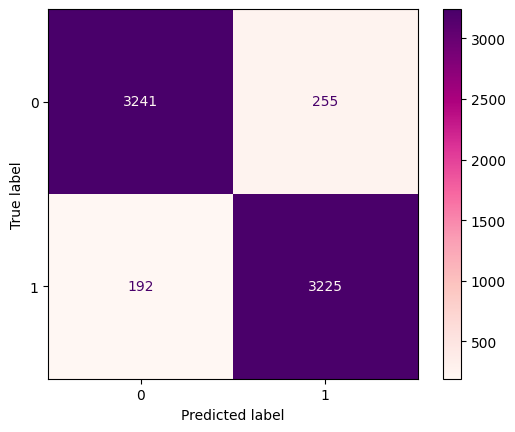

In [12]:
# Decision Tree model 
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
print("train accuracy: ", dt_clf.score(X_train, y_train))
print("val accuracy: ", dt_clf.score(X_val, y_val))

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Evaluate on validation set
y_val_pred = dt_clf.predict(X_val)
print(classification_report(y_val, y_val_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,) # set display_label according to dataset
disp.plot(cmap='RdPu')

### 3.3 Gradient Boosting

Gradient Boosting Classifier is an ensemble learning algorithm that belongs to the class of boosting methods. Boosting is a sequential process in which weak learners (typically decision trees) are trained sequentially, and each new model corrects the errors of the combined ensemble up to that point. Gradient Boosting specifically focuses on minimizing the loss function by using the gradient descent optimization technique.

Gradient Boosting offers several advantages: 
* High Predictive Accuracy
* Handles Complex Relationships
* Robust to Outliers.

However, it has drawbacks too: 
* High Computational Complexity
* Prone to Overfitting

train accuracy:  0.9094065314093522
val accuracy:  0.9017792564733111
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      3496
         1.0       0.93      0.94      0.94      3417

    accuracy                           0.94      6913
   macro avg       0.94      0.94      0.94      6913
weighted avg       0.94      0.94      0.94      6913



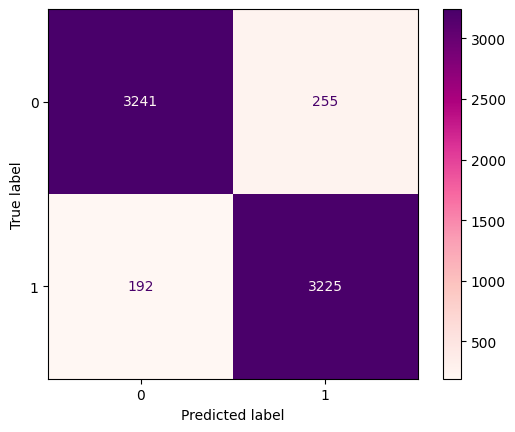

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Classifier
boosted_clf = GradientBoostingClassifier(random_state=seed)
boosted_clf.fit(X_train, y_train)
print("train accuracy: ", boosted_clf.score(X_train, y_train))
print("val accuracy: ", boosted_clf.score(X_val, y_val))

# Evaluate on validation set
y_val_pred = dt_clf.predict(X_val)
print(classification_report(y_val, y_val_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,) # set display_label according to dataset
disp.plot(cmap='RdPu')

### 3.4 K-Nearest Neighbours

The k-Nearest Neighbors (KNN) algorithm is a simple and widely used supervised machine learning model for classification and regression tasks. In KNN, the prediction for a new data point is determined by the majority class (for classification) in the feature space.

KNN is known for its simplicity and ease of implementation. However, it can be computationally expensive, especially for large datasets, as it requires calculating distances between the new data point and all existing data points. Additionally, KNN can be sensitive to irrelevant or redundant features, and proper feature scaling is often necessary for optimal performance which we have performed in to our dataset.

train accuracy:  0.9891504828035153
val accuracy:  0.9386662809200058
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      3496
         1.0       0.93      0.94      0.94      3417

    accuracy                           0.94      6913
   macro avg       0.94      0.94      0.94      6913
weighted avg       0.94      0.94      0.94      6913



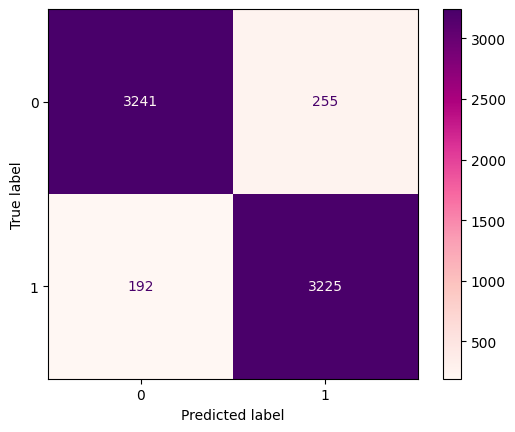

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=2)
knn_clf.fit(X_train, y_train)
print("train accuracy: ", knn_clf.score(X_train, y_train))
print("val accuracy: ", knn_clf.score(X_val, y_val))

# Evaluate on validation set
y_val_pred = dt_clf.predict(X_val)
print(classification_report(y_val, y_val_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # set display_label according to dataset
disp.plot(cmap='RdPu')

### 3.5 Random Forest

Random Forest is an ensemble learning method widely used for both classification and regression tasks in machine learning. It operates by constructing a multitude of decision trees during training and outputs the mode of the classes of the individual trees. 

Some advantages include:
* Robust to Overfitting
* Handle Non-Linearity 
* Built-in Feature Importance

Disadvantages include:
* Less Interpretable compared to Decision Trees


train accuracy:  0.9999276698853568
val accuracy:  0.967741935483871
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      3496
         1.0       0.93      0.94      0.94      3417

    accuracy                           0.94      6913
   macro avg       0.94      0.94      0.94      6913
weighted avg       0.94      0.94      0.94      6913



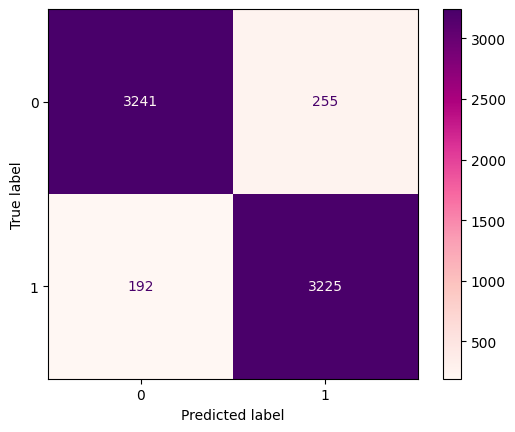

In [15]:
from sklearn.ensemble import RandomForestClassifier

rndforest_clf = RandomForestClassifier(random_state=seed)
rndforest_clf.fit(X_train, y_train)
print("train accuracy: ", rndforest_clf.score(X_train, y_train))
print("val accuracy: ", rndforest_clf.score(X_val, y_val))

# Evaluate on validation set
y_val_pred = dt_clf.predict(X_val)
print(classification_report(y_val, y_val_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,) # set display_label according to dataset
disp.plot(cmap='RdPu')

### 3.6 Neural Network

Neural network models are computational models inspired by the structure and functioning of the human brain. These models consist of interconnected nodes (neurons) organized into layers. There are many types of neural network models and the one we will be using is Multilayer Perceptron (MLP).

Multilayer perceptrons are a type of feedforward neural network with one or more hidden layers of neurons between the input and output layers. Each neuron in one layer is connected to every neuron in the next layer.

train accuracy:  0.9348305667064483
val accuracy:  0.9142195862867062
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      3496
         1.0       0.93      0.94      0.94      3417

    accuracy                           0.94      6913
   macro avg       0.94      0.94      0.94      6913
weighted avg       0.94      0.94      0.94      6913



c:\Users\zzhen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


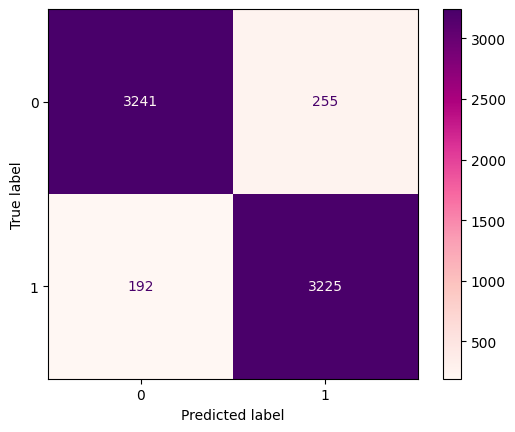

In [16]:
from sklearn.neural_network import MLPClassifier

nn_clf = MLPClassifier(random_state=seed)
nn_clf.fit(X_train, y_train)
print("train accuracy: ", nn_clf.score(X_train, y_train))
print("val accuracy: ", nn_clf.score(X_val, y_val))

# Evaluate on validation set
y_val_pred = dt_clf.predict(X_val)
print(classification_report(y_val, y_val_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,) # set display_label according to dataset
disp.plot(cmap='RdPu')

## 4 Refining Models

We note from the previous section that the Random Forest was the best performing model with the highest validation accuracy of 96.98%. However, we note that there is a gap in accuracy between the training accuracy and validation accuracy where the training accuracy is at 99.99%. This suggest that there is some form of overfitting which we hope to address by adjusting the hyperparameters.

### 4.1 Hyperparameter Tuning

Hyperparameter tuning is the process of systematically searching for the best set of hyperparameters for a machine learning model. Hyperparameters are configuration settings external to the model that cannot be learned from the data. In our case, some of the hyperparameters of interest are `min_samples_split`, `min_samples_leaf`, `and max_depth`. We want to do this through a grid search.

Grid search is a hyperparameter tuning technique that involves searching for the optimal set of hyperparameter values by exhaustively evaluating all possible combinations within a specified grid. This method is widely used to find the hyperparameter values that result in the best performance for a machine learning model.

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters: {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
train accuracy:  0.9999276698853568
val accuracy:  0.9702010704469839
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      3496
         1.0       0.97      0.97      0.97      3417

    accuracy                           0.97      6913
   macro avg       0.97      0.97      0.97      6913
weighted avg       0.97      0.97      0.97      6913



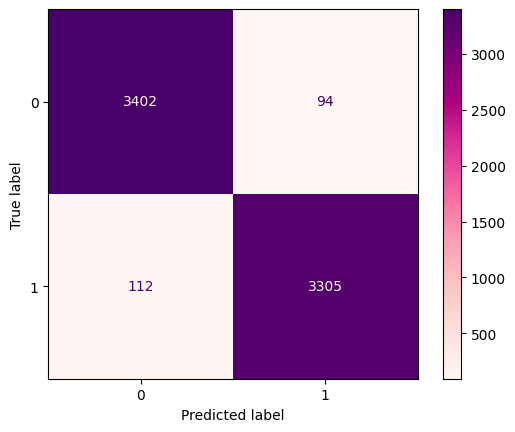

In [20]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=seed)

# Define the hyperparameters and their possible values for tuning
param_grid = {
    'n_estimators': [50, 100],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Use GridSearchCV to perform grid search
np.random.seed(seed)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='accuracy', verbose=3, n_jobs = -1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameter values
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Evaluate the model on the test set using the best hyperparameters
best_rf_model = grid_search.best_estimator_
print("train accuracy: ", best_rf_model.score(X_train, y_train))
print("val accuracy: ", best_rf_model.score(X_val, y_val))

y_val_pred = best_rf_model.predict(X_val)
print(classification_report(y_val, y_val_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,) # set display_label according to dataset
disp.plot(cmap='RdPu')

### 4.2 K-Fold Cross Validation

We have now found the best hyperparameters for this Random Forest model through hyperparameter tuning. We now would like to perform k-fold cross validation now. K-fold cross-validation is a technique used in machine learning to assess the performance and generalization ability of a model. It involves splitting the dataset into 'k' subsets, called folds. The model is trained and evaluated 'k' times, using a different fold for evaluation each time and the remaining folds for training. This process helps to provide a more robust and reliable estimate of the model's performance.

In [21]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Set the number of folds for cross-validation
num_folds = 10

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Perform cross-validation
cv_results = cross_val_score(best_rf_model, X, y, cv=kf, scoring='accuracy')

# Display results
print("Cross-Validation Accuracy: ", cv_results)
print("Mean Accuracy: ", np.mean(cv_results))
print("Standard Deviation in Accuracy: ", np.std(cv_results))

Cross-Validation Accuracy:  [0.96644489 0.9736766  0.97599074 0.9736766  0.97048611 0.96788194
 0.97048611 0.9693287  0.97482639 0.96990741]
Mean Accuracy:  0.9712705500916016
Standard Deviation in Accuracy:  0.002968696093993825


## 5 Conclusion

From the code chunk above, we observe that even after the k-fold validation, our model still maintain a high mean accuracy of 97.12% with a low standard deviation of 0.002968. This suggest the generalizability of our model which could be used to predict whether a customer will purchase life or health insurance products within the next three months.

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [22]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 

    # Identifiy numeric columns and fill null values with the median value
    numeric_cols = hidden_data.select_dtypes(include=["int64", "float64"]).columns
    hidden_data[numeric_cols] = hidden_data[numeric_cols].apply(lambda x: x.fillna(x.median()))

    # Drop non-numeric cols
    non_numeric_cols = hidden_data.select_dtypes(include=["string", "object"]).columns
    hidden_data = hidden_data.drop(columns=non_numeric_cols)

    # set the output to be pandas dataframe instead of numpy array
    set_config(transform_output="pandas")

    # Removing low variance columns
    selector = VarianceThreshold(threshold=0.005)
    hidden_data = selector.fit_transform(hidden_data)

    # Min-Max Scaling
    scaler = MinMaxScaler()
    hidden_data = scaler.fit_transform(hidden_data)

    y_pred = best_rf_model.predict(hidden_data)

    result.extend(y_pred)
    
    return result

##### Cell to check testing_hidden_data function

In [23]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

# we have modified our y through SMOTE which now has 34564 observations so need to get the orignal one to test
pred1 = testing_hidden_data(test_df)
y_original = y = df["f_purchase_lh"]
print(classification_report(y_original, pred1))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!